[Enlace al artículo](https://towardsdatascience.com/multi-step-time-series-forecasting-with-xgboost-65d6820bec39#:~:text=The%20XGBoost%20time%20series%20forecasting%20model%20is%20able%20to%20produce,set%20is%2054.61%20EUR%2FMWh.)

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import Tuple

In [2]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error

In [3]:
df_1 = pd.read_csv('Elspotprices.csv', sep=';')
df_1.head()

,HourUTC,HourDK,PriceArea,SpotPriceDKK,SpotPriceEUR
0,2022-10-19 21:00,2022-10-19 23:00,DK2,"978,750000","131,570007"
1,2022-10-19 20:00,2022-10-19 22:00,DK2,"1102,079956","148,149994"
2,2022-10-19 19:00,2022-10-19 21:00,DK2,"1090,329956","146,570007"
3,2022-10-19 18:00,2022-10-19 20:00,DK2,"1238,589966","166,500000"
4,2022-10-19 17:00,2022-10-19 19:00,DK2,"1688,050049","226,919998"


In [4]:
df_1.tail()

,HourUTC,HourDK,PriceArea,SpotPriceDKK,SpotPriceEUR
50826,2017-01-01 03:00,2017-01-01 04:00,DK2,"122,139999","16,430000"
50827,2017-01-01 02:00,2017-01-01 03:00,DK2,"119,169998","16,030001"
50828,2017-01-01 01:00,2017-01-01 02:00,DK2,"134,779999","18,129999"
50829,2017-01-01 00:00,2017-01-01 01:00,DK2,"155,369995","20,900000"
50830,2016-12-31 23:00,2017-01-01 00:00,DK2,"155,820007","20,959999"


In [5]:
# Clean Data

df = df_1[['HourDK', 'SpotPriceEUR']]
df['SpotPriceEUR'] = df['SpotPriceEUR'].str.replace(',' , '.', regex=True)
df['SpotPriceEUR'] = pd.to_numeric(df['SpotPriceEUR'])
df['HourDK'] = pd.to_datetime(df['HourDK'])
df.sort_values(by='HourDK', ascending=True, inplace=True)
df.set_index('HourDK', inplace=True)

In [6]:
# Training-Test data

df.index = pd.to_datetime(df.index)

first_day_test = '2021-01-01'
last_day_test = '2021-06-30'

training_data = df.loc[df.index < first_day_test]
test_data = df.loc[(df.index >= first_day_test) & (df.index <= last_day_test)]

In [7]:
# Hyperparameters and other important variables

target_sequence_length = 1*24

test_size = 0.20

hyperparameters = {
    "in_length": 7*24,
    "step_size": 12,
    "n_estimators": 20,
    "max_depth": 6,
    "subsample": 0.5,
    "min_child_weight": 1,
    "selected_features" : "SpotPriceEUR"
}

In [8]:
training_data

,SpotPriceEUR
HourDK,
2017-01-01 00:00:00,20.959999
2017-01-01 01:00:00,20.900000
2017-01-01 02:00:00,18.129999
2017-01-01 03:00:00,16.030001
2017-01-01 04:00:00,16.430000
...,...
2020-12-31 19:00:00,59.470001
2020-12-31 20:00:00,56.700001
2020-12-31 21:00:00,52.439999


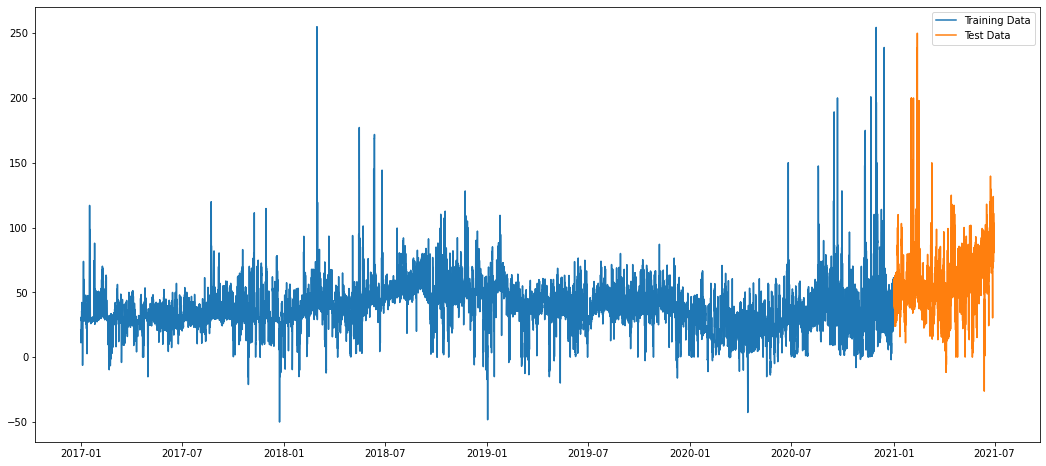

In [9]:
plt.figure(figsize=(18, 8))
plt.plot(training_data, label='Training Data')
plt.plot(test_data, label = 'Test Data')
plt.legend()
plt.show()

In [10]:
def get_indices_entire_sequence(
    data: pd.DataFrame,
    window_size: int,
    step_size: int    
    ) -> list:
    
    '''
    Produce todas las posiciones de índice inicial y final necesarias para producir las subsecuencias. 
    Devuelve una lista de tuplas. Cada tupla es (start_idx, end_idx) de una subsecuencia. 
    Estas tuplas deben utilizarse para dividir el conjunto de datos en subsecuencias. 
    A continuación, estas subsecuencias deben pasarse a una función que las corte en secuencias de input y target.
    
    Args:
    
    data (pd.DataFrame):    Conjunto de datos particionados, por ejemplo, datos de entrenamiento
    
    window_size (int):      La longitud deseada de cada subsecuencia. Debe ser
                            (longitud_secuencia_entrada + longitud_secuencia_objetivo)
                            Por ejemplo, si desea que el modelo tenga en cuenta los últimos 100
                            pasos temporales para predecir los futuros 50 
                            pasos temporales, tamaño_ventana = 100+50 = 150
    
    step_size (int):        Tamaño de cada paso a medida que la secuencia de datos es recorrida por la ventana móvil.
                            Si es 1, la primera subsecuencia será [0:tamaño_ventana], y la siguiente será [1:tamaño_ventana].
                            
    Returns
    
    indices: lista de tuplas.
    '''
    
    stop_position = len(data)-1
    
    # Inicio de la primera subsecuencia en la posición índice 0
    
    subseq_first_idx = 0
    
    subseq_last_idx = window_size
    
    indices = []
    
    while subseq_last_idx <= stop_position:
        indices.append((subseq_first_idx, subseq_last_idx))
        subseq_first_idx += step_size
        subseq_last_idx += step_size
        
    return indices
    

In [11]:
training_indices = get_indices_entire_sequence(
    data = training_data,
    window_size = hyperparameters['in_length'] + target_sequence_length,
    step_size = hyperparameters['step_size'] 
)

In [12]:
training_indices

[(0, 192),
 (12, 204),
 (24, 216),
 (36, 228),
 (48, 240),
 (60, 252),
 (72, 264),
 (84, 276),
 (96, 288),
 (108, 300),
 (120, 312),
 (132, 324),
 (144, 336),
 (156, 348),
 (168, 360),
 (180, 372),
 (192, 384),
 (204, 396),
 (216, 408),
 (228, 420),
 (240, 432),
 (252, 444),
 (264, 456),
 (276, 468),
 (288, 480),
 (300, 492),
 (312, 504),
 (324, 516),
 (336, 528),
 (348, 540),
 (360, 552),
 (372, 564),
 (384, 576),
 (396, 588),
 (408, 600),
 (420, 612),
 (432, 624),
 (444, 636),
 (456, 648),
 (468, 660),
 (480, 672),
 (492, 684),
 (504, 696),
 (516, 708),
 (528, 720),
 (540, 732),
 (552, 744),
 (564, 756),
 (576, 768),
 (588, 780),
 (600, 792),
 (612, 804),
 (624, 816),
 (636, 828),
 (648, 840),
 (660, 852),
 (672, 864),
 (684, 876),
 (696, 888),
 (708, 900),
 (720, 912),
 (732, 924),
 (744, 936),
 (756, 948),
 (768, 960),
 (780, 972),
 (792, 984),
 (804, 996),
 (816, 1008),
 (828, 1020),
 (840, 1032),
 (852, 1044),
 (864, 1056),
 (876, 1068),
 (888, 1080),
 (900, 1092),
 (912, 1104),


In [13]:
test_indices = get_indices_entire_sequence(
    data = test_data,
    window_size = hyperparameters['in_length'] + target_sequence_length,
    step_size = 24
)

In [14]:
test_indices

[(0, 192),
 (24, 216),
 (48, 240),
 (72, 264),
 (96, 288),
 (120, 312),
 (144, 336),
 (168, 360),
 (192, 384),
 (216, 408),
 (240, 432),
 (264, 456),
 (288, 480),
 (312, 504),
 (336, 528),
 (360, 552),
 (384, 576),
 (408, 600),
 (432, 624),
 (456, 648),
 (480, 672),
 (504, 696),
 (528, 720),
 (552, 744),
 (576, 768),
 (600, 792),
 (624, 816),
 (648, 840),
 (672, 864),
 (696, 888),
 (720, 912),
 (744, 936),
 (768, 960),
 (792, 984),
 (816, 1008),
 (840, 1032),
 (864, 1056),
 (888, 1080),
 (912, 1104),
 (936, 1128),
 (960, 1152),
 (984, 1176),
 (1008, 1200),
 (1032, 1224),
 (1056, 1248),
 (1080, 1272),
 (1104, 1296),
 (1128, 1320),
 (1152, 1344),
 (1176, 1368),
 (1200, 1392),
 (1224, 1416),
 (1248, 1440),
 (1272, 1464),
 (1296, 1488),
 (1320, 1512),
 (1344, 1536),
 (1368, 1560),
 (1392, 1584),
 (1416, 1608),
 (1440, 1632),
 (1464, 1656),
 (1488, 1680),
 (1512, 1704),
 (1536, 1728),
 (1560, 1752),
 (1584, 1776),
 (1608, 1800),
 (1632, 1824),
 (1656, 1848),
 (1680, 1872),
 (1704, 1896),
 (

In [15]:
def get_xgboost_x_y(
        indices: list,
        data:  np.array,
        target_sequence_length,
        input_seq_len: int
    ) -> Tuple[np.array, np.array]:
    
    '''
    
    Args:

    indices:    lista de posiciones de indice en las que se deben dividir los datos

    data:       serie de tiempo univariada

    target_sequence_length: el horizonte de pronóstico, m

    input_seq_len:  longitud de la secuencia de entrada, n

    Output:

    all_x:      np.array con toda el input del modelo, es decir, la X, que tiene la forma (número de instancias, n).
    
    all_y:      np.array con todas las secuencias del target, es decir, la Y, que tiene la forma (número de instancias, m).

    '''
    
    print("Preparing data...")
    
    # Bucle sobre la lista de índices de entrenamiento
    
    for i, idx in enumerate(indices):
        
        # Divide los datos en instancias de longitud: input length + target length
        
        data_instance = data[idx[0]:idx[1]]
        
        x = data_instance[0:input_seq_len]
        
        assert len(x) == input_seq_len
        
        y = data_instance[input_seq_len:input_seq_len+target_sequence_length]
        
        # Crear objetos all_y y all_x en la primera iteración del bucle
        
        if i == 0:
            
            all_y = y.reshape(1, -1)
            
            all_x = x.reshape(1, -1)
            
        else:
            
            all_y = np.concatenate((all_y, y.reshape(1, -1)), axis=0)
            
            all_x = np.concatenate((all_x, x.reshape(1, -1)), axis=0)
            
    print("Finished preparing data")
    
    return all_x, all_y
        
        
    

In [16]:
training_data.head(3)

,SpotPriceEUR
HourDK,
2017-01-01 00:00:00,20.959999
2017-01-01 01:00:00,20.900000
2017-01-01 02:00:00,18.129999


In [17]:
# Obtain (x,y) pairs for training data

x_train, y_train = get_xgboost_x_y(
    indices = training_indices,
    data = training_data['SpotPriceEUR'].to_numpy(),
    target_sequence_length = target_sequence_length,
    input_seq_len = hyperparameters['in_length']
)

Preparing data...
Finished preparing data


In [18]:
training_data.head(10)

,SpotPriceEUR
HourDK,
2017-01-01 00:00:00,20.959999
2017-01-01 01:00:00,20.900000
2017-01-01 02:00:00,18.129999
2017-01-01 03:00:00,16.030001
2017-01-01 04:00:00,16.430000
2017-01-01 05:00:00,13.750000
2017-01-01 06:00:00,11.100000
2017-01-01 07:00:00,15.470000
2017-01-01 08:00:00,16.879999


In [19]:
x_train[0][:10]

array([20.959999, 20.9     , 18.129999, 16.030001, 16.43    , 13.75    ,
       11.1     , 15.47    , 16.879999, 21.809999])

In [20]:
y_train

array([[30.75    , 30.639999, 30.530001, ..., 30.950001, 30.549999,
        29.889999],
       [37.610001, 36.959999, 35.139999, ..., 44.919998, 45.34    ,
        45.07    ],
       [29.559999, 29.110001, 28.99    , ..., 30.07    , 29.57    ,
        28.83    ],
       ...,
       [55.      , 52.41    , 53.639999, ..., 52.700001, 52.169998,
        50.700001],
       [34.459999, 20.700001, 20.27    , ..., 45.759998, 23.129999,
        20.940001],
       [54.290001, 52.779999, 53.669998, ..., 47.5     , 43.23    ,
        43.57    ]])

In [21]:
# Obtain (x,y) pairs for test data

x_test, y_test = get_xgboost_x_y(
    indices = test_indices,
    data = test_data['SpotPriceEUR'].to_numpy(),
    target_sequence_length = target_sequence_length,
    input_seq_len = hyperparameters['in_length']
)

Preparing data...
Finished preparing data


## Train Model

In [22]:
# Initialize model

model = xgb.XGBRegressor(
    n_estimators = hyperparameters['n_estimators'],
    max_depth = hyperparameters['max_depth'],
    subsample = hyperparameters['subsample'],
    min_child_weight = hyperparameters['min_child_weight'],
    objective = 'reg:squarederror',
    tree_method = 'hist'
)

trained_model = MultiOutputRegressor(model).fit(x_train, y_train)

train_forecast = trained_model.predict(x_train)

## Test Model

In [23]:
test_forecast = trained_model.predict(x_test)

test_mae = mean_absolute_error(y_test, test_forecast)
print("MAE: ", test_mae)

MAE:  12.854771359873572


In [24]:
y_test[0][0:24]

array([ 49.310001,  47.380001,  45.779999,  44.509998,  45.689999,
        50.330002,  59.709999,  79.559998, 103.540001, 107.800003,
       107.32    , 104.260002,  99.910004,  95.269997,  92.720001,
        95.419998,  95.      , 110.      ,  99.949997,  80.120003,
        64.239998,  59.43    ,  56.220001,  51.75    ])

In [25]:
test_forecast[0][0:24].flatten()

array([48.215137, 47.053883, 45.795666, 50.176186, 52.70801 , 47.863224,
       45.39951 , 71.01749 , 52.7739  , 88.85723 , 83.33378 , 59.595592,
       47.487564, 69.07291 , 55.13968 , 50.970036, 70.95734 , 67.32264 ,
       72.433784, 77.07542 , 47.803005, 51.399864, 39.495773, 50.48199 ],
      dtype=float32)

In [26]:
forecast_test_df = pd.DataFrame(
    {
        "Forecast" : test_forecast.flatten(),
        "Targets": y_test.flatten()
    },
    index = range(len(y_test.flatten()))
)

forecast_test_df

,Forecast,Targets
0,48.215137,49.310001
1,47.053883,47.380001
2,45.795666,45.779999
3,50.176186,44.509998
4,52.708012,45.689999
...,...,...
4123,38.868820,117.959999
4124,67.613770,98.980003
4125,59.571545,97.489998
4126,61.187729,89.589996


In [27]:
def calculate_mape(y_true, y_pred):

    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [28]:
forecast_test_df_1mes = forecast_test_df[:744]

In [29]:
mape = calculate_mape(
    y_true = forecast_test_df_1mes['Targets'],
    y_pred = forecast_test_df_1mes['Forecast']
)

print("MAPE en un mes: ", mape)

MAPE en un mes:  19.421207513774103
